In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext, datasets, math
from torchtext.vocab import vocab as torchTextVocab
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer
from tqdm import tqdm
import random, math, time

c:\Users\anhng\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


# 1) Load Dataset

In [3]:
dataset = datasets.load_dataset("codeparrot/github-jupyter-code-to-text", split="train")
iter_dataset = iter(dataset)
list(next(iter_dataset))

Found cached dataset parquet (C:/Users/anhng/.cache/huggingface/datasets/codeparrot___parquet/codeparrot--github-jupyter-code-to-text-cf9b56d996fd17e1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


['repo_name', 'path', 'license', 'content']

In [4]:
all_repos = []
count = 0
threshold = 15000

for repo in iter_dataset:
    all_repos.append(repo['content'])
    count += 1
    print(f"Repositories collected: {len(all_repos)}")
    if count == threshold:
        break
idx = 0
print(all_repos[idx][:])

Repositories collected: 1
Repositories collected: 2
Repositories collected: 3
Repositories collected: 4
Repositories collected: 5
Repositories collected: 6
Repositories collected: 7
Repositories collected: 8
Repositories collected: 9
Repositories collected: 10
Repositories collected: 11
Repositories collected: 12
Repositories collected: 13
Repositories collected: 14
Repositories collected: 15
Repositories collected: 16
Repositories collected: 17
Repositories collected: 18
Repositories collected: 19
Repositories collected: 20
Repositories collected: 21
Repositories collected: 22
Repositories collected: 23
Repositories collected: 24
Repositories collected: 25
Repositories collected: 26
Repositories collected: 27
Repositories collected: 28
Repositories collected: 29
Repositories collected: 30
Repositories collected: 31
Repositories collected: 32
Repositories collected: 33
Repositories collected: 34
Repositories collected: 35
Repositories collected: 36
Repositories collected: 37
Repositori

### Splitting into train, validation, and test sets

In [5]:
Len = len(all_repos)

In [6]:
import random

random.shuffle(all_repos)

train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.2

n_samples = len(all_repos)
train_end = int(train_ratio * n_samples)
valid_end = int((train_ratio + valid_ratio) * n_samples)

train = all_repos[:train_end]
valid = all_repos[train_end:valid_end]
test = all_repos[valid_end:]

print(f"Number of training samples: {len(train)}")
print(f"Number of validation samples: {len(valid)}")
print(f"Number of test samples: {len(test)}")

Number of training samples: 10500
Number of validation samples: 2999
Number of test samples: 1501


In [7]:
from torchdata.datapipes.iter import IterableWrapper

In [8]:
train = IterableWrapper(train)
valid = IterableWrapper(valid)
test  = IterableWrapper(test)

In [9]:
len(list(iter(train))), len(list(iter(valid))), len(list(iter(test)))

(10500, 2999, 1501)

# 3) Processing

## Tokenizing

In [10]:
from pygments import lex
from pygments.lexers import PythonLexer

def python_code_tokenizer(content):
    tokenized_code = [token[1] for token in lex(content, lexer=PythonLexer())]
    return tokenized_code

#### Testing python_code_tokenizer function

In [11]:
## Sample before tokenization 
sample = next(iter(train))
print(sample[:1000])

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("white")

"""
Explanation: San Diego Burrito Analytics
Scott Cole
23 April 2016
This notebook contains analyses on the burrito ratings in San Diego, including:
* How each metric correlates with one another.
* Linear model of how each dimension contributes to the overall rating
Default imports
End of explanation
"""


filename="burrito_current.csv"
df = pd.read_csv(filename)
N = df.shape[0]

"""
Explanation: Load data
End of explanation
"""


# Identify california burritos
def caliburritoidx(x):
    import re
    idx = []
    for b in range(len(x)):
        re4str = re.compile('.*cali.*', re.IGNORECASE)
        if re4str.match(x[b]) is not None:
            idx.append(b)
    return idx

caliidx = caliburritoidx(df.Burrito)
Ncaliidx = np.arange(len(df))
Ncaliidx = np.delete(Ncaliidx,caliidx)

met_

In [12]:
## Sample after tokenization
tokenized_sample = python_code_tokenizer(sample)
print(tokenized_sample[:50])

['%', 'config', ' ', 'InlineBackend', '.', 'figure_format', ' ', '=', ' ', "'", 'retina', "'", '\n', '%', 'matplotlib', ' ', 'inline', '\n', '\n', 'import', ' ', 'numpy', ' ', 'as', ' ', 'np', '\n', 'import', ' ', 'scipy', ' ', 'as', ' ', 'sp', '\n', 'import', ' ', 'matplotlib', '.', 'pyplot', ' ', 'as', ' ', 'plt', '\n', 'import', ' ', 'pandas', ' ', 'as']


In [13]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data):
    for data_sample in data:
        yield python_code_tokenizer(data_sample)

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [14]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

## Text to integers (Numericalization)

In [15]:
from torchtext.vocab import build_vocab_from_iterator

# Create torchtext's Vocab object 
vocab = build_vocab_from_iterator(yield_tokens(train), 
                                                min_freq=2,   #if not, everything will be treated as UNK
                                                specials=special_symbols,
                                                special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
vocab.set_default_index(UNK_IDX)

In [16]:
#see some example
vocab(['import', 'numpy', 'as', 'np'])

[25, 79, 40, 20]

In [17]:
#we can reverse it....
mapping = vocab.get_itos()

#print 22, for example
mapping[22]

'print'

In [18]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [19]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [20]:
#check unique vocabularies
len(mapping)

223764

In [21]:
torch.save(vocab, 'vocab.pth')

# 4) Preparing the dataloader


In [23]:
seq_len = 50
def get_pair(data):
    pairs = []
    
    for end_idx in range(1, len(data) - 1):
        start_idx = end_idx - seq_len
        
        if start_idx < 0:
            start_idx = 0
            
        src = data[start_idx:end_idx]
        trg = data[start_idx + 1:end_idx + 1] # trg simply is ahead of src by 1   
        
        
    return src, trg

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = sequential_transforms(python_code_tokenizer, #Tokenization
                                               vocab, #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    
    for sample in batch:
        processed_code = text_transform(sample)
        src, trg = get_pair(processed_code)
        src_batch.append(src)
        trg_batch.append(trg)
        src_len_batch.append(len(src))
    
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [25]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

c:\Users\anhng\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\graph_settings.py:74: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [26]:
for src, seq_length, trg in train_loader:
    break

# 5) Design the model

In [27]:
class MultiHeadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads  #make sure it's divisible....
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc   = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.scale   = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, q, k, v, mask = None):
        b = q.shape[0]
        
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)
        #Q, K, V = [b, l, h]
        
        #reshape them into head_dim
        #reshape them to [b, n_heads, l, head_dim]
        Q = Q.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q, K, V = [b, n_heads, l, head_dim]
        
        #e = QK/sqrt(dk)
        e = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #e: [b, n_heads, ql, kl]
        
        if mask is not None:
            e = e.masked_fill(mask == 0, -1e10)
            
        a = torch.softmax(e, dim=-1)
        
        #eV
        x = torch.matmul(self.dropout(a), V)
        #x: [b, n_heads, ql, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x: [b, ql, n_heads, head_dim]
        
        #concat them together
        x = x.view(b, -1, self.hid_dim)
        #x: [b, ql, h]
        
        x = self.fc(x)
        #x = [b, ql, h]
        
        return x, a

## Decoder

In [28]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, trg_mask):
        
        #trg = [batch size, trg len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg
class PositionwiseFeedforwardLayer(nn.Module):
        
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.fc2(self.dropout(torch.relu(self.fc1(x))))   
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, trg_pad_idx, device, max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.trg_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.trg_pad_idx = trg_pad_idx
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask
        
    def forward(self, trg):
        #trg = [batch size, trg len]
        
        trg_mask = self.make_trg_mask(trg)
        #trg_mask = [batch size, 1, trg len, trg len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)          
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.trg_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg = [batch size, trg len, hid dim]
                
        for layer in self.layers:
            trg = layer(trg, trg_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]
            
        return output

# 6) Training

In [29]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [30]:
OUTPUT_DIM = len(vocab)
HID_DIM = 256
DEC_LAYERS = 3
DEC_HEADS = 8
DEC_PF_DIM = 512
DEC_DROPOUT = 0.1

TRG_PAD_IDX = PAD_IDX

model = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, 
              DEC_PF_DIM, DEC_DROPOUT, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Decoder(
  (trg_embedding): Embedding(223764, 256)
  (pos_embedding): Embedding(100, 256)
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (positionwise_feedforward): PositionwiseFeedforwardLayer(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Dec

In [31]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

57283584
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
57283584
223764
______
116397844


In [32]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [33]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output = model(src[:,:-1])  
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1)    #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [34]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output = model(src[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [35]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [37]:
best_valid_loss = float('inf')
num_epochs = 7
clip       = 1

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 17m 54s
	Train Loss: 5.017 | Train PPL: 150.938
	 Val. Loss: 2.865 |  Val. PPL:  17.546
Epoch: 02 | Time: 19m 21s
	Train Loss: 2.816 | Train PPL:  16.705
	 Val. Loss: 2.562 |  Val. PPL:  12.962
Epoch: 03 | Time: 20m 35s
	Train Loss: 2.396 | Train PPL:  10.980
	 Val. Loss: 2.451 |  Val. PPL:  11.598
Epoch: 04 | Time: 18m 43s
	Train Loss: 2.118 | Train PPL:   8.314
	 Val. Loss: 2.387 |  Val. PPL:  10.879
Epoch: 05 | Time: 18m 32s
	Train Loss: 1.894 | Train PPL:   6.645
	 Val. Loss: 2.353 |  Val. PPL:  10.512
Epoch: 06 | Time: 20m 21s
	Train Loss: 1.696 | Train PPL:   5.452
	 Val. Loss: 2.358 |  Val. PPL:  10.567
Epoch: 07 | Time: 20m 9s
	Train Loss: 1.521 | Train PPL:   4.575
	 Val. Loss: 2.379 |  Val. PPL:  10.792


Text(0, 0.5, 'loss')

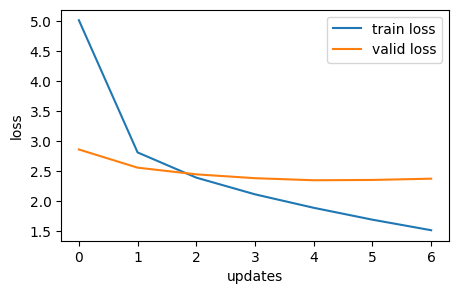

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [39]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.360 | Test PPL:  10.593 |


# 7) Inferences

In [71]:
sample ="import numpy"

In [72]:
sample_text = text_transform(sample[0]).to(device)
sample_text

tensor([ 2, 34,  4,  3])

In [73]:
sample_text = sample_text.reshape(1, -1)  #because batch_size is 1

In [74]:
sample_text.shape

torch.Size([1, 4])

In [75]:
text_length = torch.tensor([sample_text.size(0)]).to(dtype=torch.int64)

In [76]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output = model(sample_text) #turn off teacher forcing

In [77]:
output.shape

torch.Size([1, 4, 223764])

Since batch size is 1, we just take off that dimension

In [78]:
output = output.squeeze(0)

In [79]:
output.shape

torch.Size([4, 223764])

We shall remove the first token since it's zeroes anyway

In [80]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([3, 223764])

Then we just take the top token with highest probabilities

In [81]:
output_max = output.argmax(1) #returns max indices

In [82]:
output_max

tensor([4, 4, 4])

In [83]:
mapping = vocab.get_itos()

In [84]:
for token in output_max:
    print(mapping[token.item()])

In [85]:
output_max

tensor([4, 4, 4])